## Load and Preprocess Data

In [4]:
import os 
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## Dataset Loading

In [6]:
Dataset='/kaggle/input/melanoma-cancer-dataset'
Train_dataset=os.path.join(Dataset,'train')
Test_dataset=os.path.join(Dataset,'test')

In [9]:
import os

Dataset = '/kaggle/input/melanoma-cancer-dataset'
Train_dataset = os.path.join(Dataset, 'train')
Test_dataset = os.path.join(Dataset, 'test')

# List class folders in train and test
print("Train classes:", os.listdir(Train_dataset))
print("Test classes:", os.listdir(Test_dataset))

# List sample images in one class
sample_class = os.listdir(Train_dataset)[0]
print("Sample images from class:", sample_class)
print(os.listdir(os.path.join(Train_dataset, sample_class))[:5])


Train classes: ['Benign', 'Malignant']
Test classes: ['Benign', 'Malignant']
Sample images from class: Benign
['6234.jpg', '1269.jpg', '3863.jpg', '6241.jpg', '623.jpg']


## Exploratory Data Analysis(EDA)

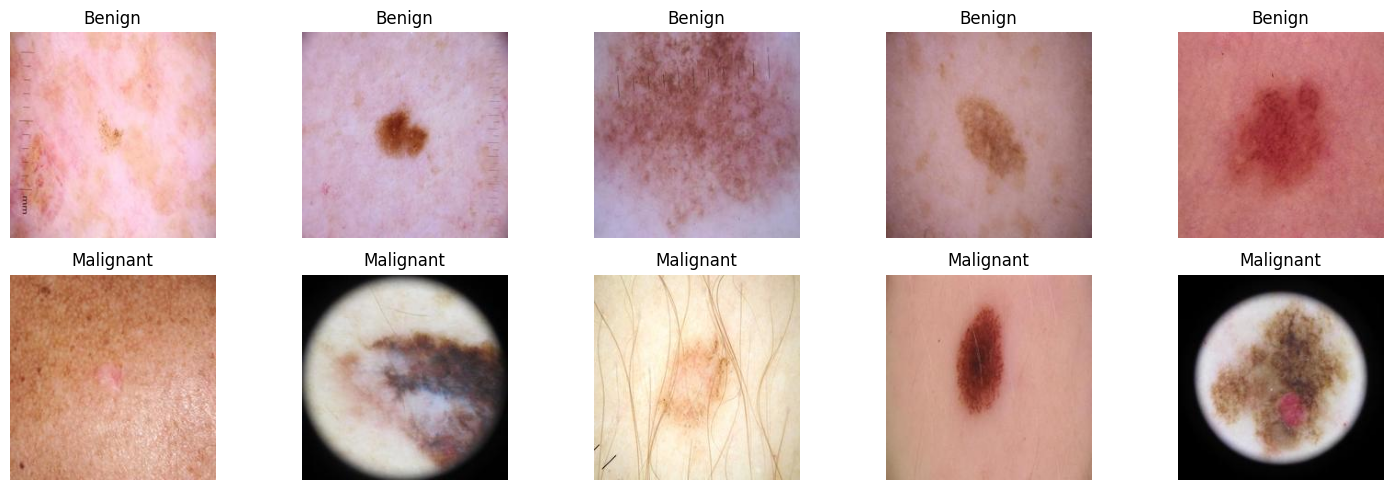

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def show_sample_images(base_dir, class_names, num_images=5):
    plt.figure(figsize=(15, 5))
    img_index = 1
    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        image_files = os.listdir(class_dir)[:num_images]
        for image_file in image_files:
            img_path = os.path.join(class_dir, image_file)
            img = mpimg.imread(img_path)
            plt.subplot(len(class_names), num_images, img_index)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
            img_index += 1
    plt.tight_layout()
    plt.show()

# Show images
show_sample_images(Train_dataset, ['Benign', 'Malignant'])


In [12]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Corrected train data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,     
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,            
    horizontal_flip=True
)

# Test data generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load train data
train_generator = train_datagen.flow_from_directory(
    directory=Train_dataset,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',     
    shuffle=True
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    directory=Test_dataset,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Building The CNN Model

In [18]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Feature extraction part
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Classification part
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Final output layer for binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750012807.553305      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1)


In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1750013145.112166     114 service.cc:148] XLA service 0x7b17140055d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750013145.113255     114 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750013145.547628     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/371 ━━━━━━━━━━━━━━━━━━━━ 49:12 8s/step - accuracy: 0.5312 - loss: 0.6951

I0000 00:00:1750013149.677705     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


371/371 ━━━━━━━━━━━━━━━━━━━━ 217s 564ms/step - accuracy: 0.6926 - loss: 0.6832 - val_accuracy: 0.8286 - val_loss: 0.3731 - learning_rate: 0.0010
Epoch 2/30
  1/371 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.7812 - loss: 0.4459

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7812 - loss: 0.4459 - val_accuracy: 0.8231 - val_loss: 0.3800 - learning_rate: 0.0010
Epoch 3/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 133s 358ms/step - accuracy: 0.8137 - loss: 0.4153 - val_accuracy: 0.8291 - val_loss: 0.3975 - learning_rate: 0.0010
Epoch 4/30
  1/371 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8750 - loss: 0.3635
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8750 - loss: 0.3635 - val_accuracy: 0.8291 - val_loss: 0.3924 - learning_rate: 0.0010
Epoch 5/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 135s 365ms/step - accuracy: 0.8391 - loss: 0.3686 - val_accuracy: 0.8821 - val_loss: 0.3301 - learning_rate: 2.0000e-04
Epoch 6/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8750 - loss: 0.2557 - val_accuracy: 0.8846 - val_loss: 0.3296 - learning_rate: 2.0000e-04
Epoch 7/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 134s 362ms/step - accuracy: 0.8418 - lo

In [21]:
model.save("skin_cancer_cnn.h5")

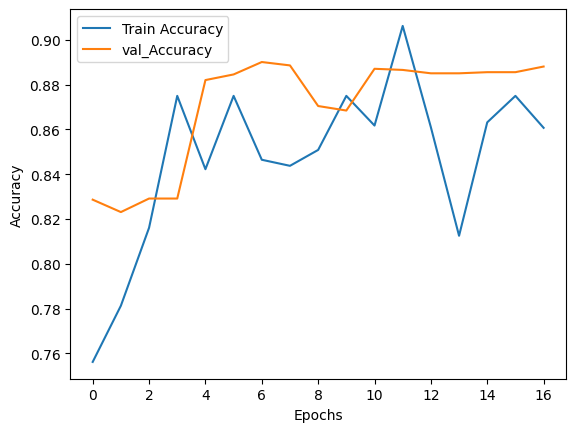

In [23]:
## Plot Training History
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="val_Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Evaluate Model Performance

In [29]:
# Get predictions
test_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE)

# Convert probabilities to binary labels
test_pred_label = (test_pred > 0.5).astype('int32')  # or use np.int32 if preferred
#test_true_labels=test_generator.classes[:]len(test_pred_labels)

#classification_report(test_true)
# Display first few predictions
print(test_pred_label[:10])


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
[[0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]]


In [30]:
test_pred = model.predict(test_generator)  # No need to specify steps
test_pred_label = (test_pred > 0.5).astype('int32')

true_labels = test_generator.classes
print("Prediction shape:", test_pred_label.shape)
print("True label shape:", true_labels.shape)

# Now it's safe to compute metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_labels, test_pred_label))




63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
Prediction shape: (2000, 1)
True label shape: (2000,)
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1000
           1       0.89      0.88      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



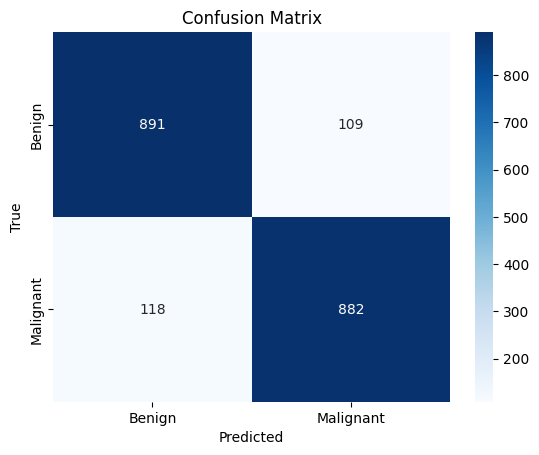

In [31]:
cm = confusion_matrix(true_labels, test_pred_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Prediction System

In [33]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/working/skin_cancer_cnn.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


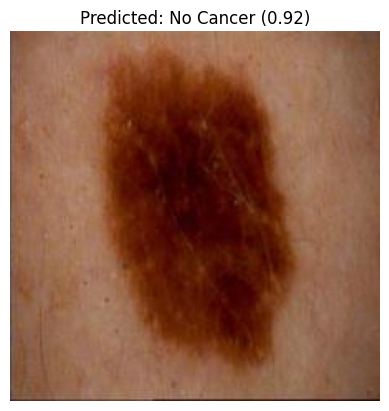

In [43]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load image
img_path = '/kaggle/input/melanoma-cancer-dataset/test/Benign/6299.jpg'  # Example
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize like during training

# Predict
prediction = model.predict(img_array)
class_label = 'Cancer' if prediction[0][0] > 0.5 else 'No Cancer'

# Show image with prediction
plt.imshow(img)
confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]
plt.title(f"Predicted: {class_label} ({confidence:.2f})")
plt.axis("off")
plt.show()